In [1]:


import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from tqdm.notebook import tqdm, trange
import torch
import autograd.numpy as np
import autograd.scipy.stats as stats
import scipy.optimize as optimize
from autograd.scipy.linalg import logm
from autograd import grad, jacobian, hessian
import numpy
import scipy
import pandas as pd
import ipywidgets as widgets
import time
from sklearn import linear_model



In [2]:
def decode_q_params(encoded_q):
        shape = len(encoded_q)
        mean_shape = 3
        A_shape = (int(np.sqrt(shape - mean_shape)), int(np.sqrt(shape - mean_shape)))
        mean = encoded_q[0:mean_shape]
        A = encoded_q[mean_shape:shape].reshape(A_shape)
        return mean, A
def encode_q_params(q_params):
    mean, A = q_params
    return np.array(list(mean) + list(A.flatten()))

def decode_d(encoded_d, dim=2):
    return encoded_d.reshape(int(len(encoded_d)/dim), dim)
def encode_d(d):
    return d.flatten()

def augment_d(d):
    return np.concatenate((d.T, [np.ones(len(d))]), axis=0).T

In [3]:


def stable_multivariate_gaussian_logpdf(x, mu, cov):
    n = cov.shape[-1]
    x_mu = x - mu
    try:
        _, log_det = np.linalg.slogdet(cov)
        cov_inv = np.linalg.inv(cov)
        prod = np.einsum('...i, ...ij, ...j->...', x_mu, cov_inv, x_mu) # todo: find a way to make this understandable
        log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + prod)
    except np.linalg.LinAlgError:
        cov_modified = cov + np.eye(n) * 1e-8
        _, log_det = np.linalg.slogdet(cov_modified)
        cov_inv = np.linalg.inv(cov_modified)
        prod = np.einsum('...i, ...ij, ...j->...', x_mu, cov_inv, x_mu)
        log_prob = -0.5 * (n * np.log(2 * np.pi) + log_det + prod)
    return log_prob



In [98]:


def get_posterior(d, y_i):
    d = augment_d(d)
    var_y = np.var(y_i) * np.eye(len(y_i))
    covariance_prior = A_prior @ A_prior.T
    mean_theta = covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ (y_i - d @ mean_prior)
    cov_theta = covariance_prior - covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ d @ covariance_prior
    return mean_theta, np.linalg.cholesky(cov_theta)
def get_posteriors(d, y):
    d = augment_d(d)
    var_y = noise * np.eye(y.shape[1])
    covariance_prior = A_prior @ A_prior.T
    mean_theta = covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ (y - d @ mean_prior).T
    cov_theta = covariance_prior - covariance_prior @ d.T @ np.linalg.inv(var_y + d @ covariance_prior @ d.T) @ d @ covariance_prior
    return mean_theta, np.linalg.cholesky(cov_theta)



In [128]:


#d0 = np.random.randn(20,2)
d0 = np.array([[0,0] for i in range(10)])
#A_prior = np.array([[5, -2, 1],
#              [-2, 4, -1],
#              [1, -1, 3]])
A_prior = np.eye(3)
mean_prior = np.array([0,0, 0])
noise = 1



In [129]:
def MI(d, N=50):
    thetas = np.random.multivariate_normal(mean_prior, A_prior @ A_prior.T, size=N)
    z = np.random.randn(N, d.shape[0]) * noise
    y = thetas @ augment_d(d).T + z
    mean, A = get_posteriors(d, y)
    #print(mean.T)
    results = [stable_multivariate_gaussian_logpdf(theta_i, mean_i, A @ A.T) for theta_i, mean_i in zip(thetas, mean.T)]
    return 1/N * np.sum(results) - 0.5 * np.log(np.linalg.det(2 * np.pi * np.e * (A_prior @ A_prior.T)))

In [130]:
#get_posteriors(np.array([d0, d0]).T, np.array([augment_d(d0) @ mean_prior, augment_d(d0) @ mean_prior]))

In [131]:
def KLD(mean_q, A_q, mean_p, A_p):
        sigma_q = (A_q @ A_q.T)
        sigma_p = (A_p @ A_p.T)
        bar_sigma_q = np.linalg.norm(sigma_q)
        bar_sigma_p = np.linalg.norm(sigma_p)
        k = len(mean_q)
        return 0.5 * (np.trace(np.linalg.inv(sigma_p) @ sigma_q) + (mean_p - mean_q).T @ np.linalg.inv(sigma_p) @ (mean_p - mean_q) - k + np.log(bar_sigma_p/bar_sigma_q))
def KLD_opt(mean_q, A_q, mean_p, A_p):
    # Compute Cholesky decomposition
    L_p = np.linalg.cholesky(A_p @ A_p.T)
    L_q = np.linalg.cholesky(A_q @ A_q.T)

    # Compute trace term
    trace_term = np.sum(np.log(np.diag(L_p))) - np.sum(np.log(np.diag(L_q)))

    # Compute mean difference term
    mean_diff = mean_p - mean_q
    mean_diff_term = np.dot(np.linalg.solve(L_p.T, np.linalg.solve(L_p, mean_diff)), mean_diff)

    # Compute bar_sigma_p and bar_sigma_q
    bar_sigma_q = np.linalg.norm(L_q)
    bar_sigma_p = np.linalg.norm(L_p)

    k = len(mean_q)

    return 0.5 * (trace_term + mean_diff_term - k + np.log(bar_sigma_p / bar_sigma_q))
def log_likelihood_opt(y, theta, d):
    d_offset = np.concatenate((d.T, np.ones((1, len(d)))), axis=0).T
    likelihood_cov = np.mean(np.square(y - np.matmul(theta.T, d_offset.T)), axis=1)[:, np.newaxis, np.newaxis] * np.eye(len(d))[np.newaxis, ...]
    likelihood_mean = np.matmul(theta.T, d_offset.T)
    log_likelihoods = stable_multivariate_gaussian_logpdf(y, likelihood_mean, likelihood_cov)
    return log_likelihoods
def log_likelihood(y, theta, d):
    #print(np.array([np.eye(len(d)) for _ in theta.T]).shape)
    d_offset = np.concatenate((d.T, [np.ones(len(d))]), axis=0).T
    #print(np.mean(np.square(y - theta.T @ d.T), axis=1))
    #print(d)
    likelihood_cov = np.mean(np.square(y - theta.T @ d_offset.T), axis=1)[:, np.newaxis, np.newaxis] * np.array([np.eye(len(d)) for _ in theta.T])
    #print(likelihood_cov)
    likelihood_mean = theta.T @ d_offset.T
    return [stable_multivariate_gaussian_logpdf(y, mean, cov) for mean, cov in zip(likelihood_mean, likelihood_cov)]
def elbo_optimized(q_params, d, y_i, shape=3, batch_size = 500):
    #print("Computing elbo for ", q_params, d, y_i)
    mean, A = q_params
    #values = np.random.multivariate_normal(np.zeros(shape), np.eye(shape), size=batch_size)
    #theta = mean + A @ values.T
    sample_values = np.random.multivariate_normal(np.zeros(3), np.eye(3), size=batch_size)
    theta = np.expand_dims(mean, axis=1) + A @ sample_values.T
    lik = log_likelihood_opt(y_i, theta, d)
    mean_term = (1/batch_size) * np.sum(lik)
    kld_term = KLD(mean, A, mean_prior, A_prior)
    #print(lik[0])
    
    return mean_term - kld_term

def reshape_jacobian(jac):
    return np.array([encode_d(jac[i]) for i in range(jac.shape[0]) ])

In [132]:
def q_grad(theta, q_params, d, y_i):
    q_mean, q_A = q_params
    inverse_hessian = np.linalg.inv(hessian(lambda eq: elbo_optimized(decode_q_params(eq), d, y_i))(encode_q_params(q_params)))
    mixed_partials = jacobian(lambda eq: grad(lambda d: elbo_optimized(decode_q_params(eq), decode_d(d), y_i))(encode_d(d)))(encode_q_params(q_params)).T
    jac = - inverse_hessian @ mixed_partials
    #print(grad(lambda eq: np.exp(stable_multivariate_gaussian_logpdf(theta, decode_q_params(eq)[0], decode_q_params(eq)[1])))(encode_q_params(q_params)) @ jac)
    return jac
def MI_grad(d):
    N = 2
    M = 2
    results = []
    for i in tqdm(range(int(N)), desc="Inner loop", leave=False):
        eps = np.random.randn(N, len(d))
        zs = np.random.randn(M, 3)
        for j in range(M):
            theta_j = mean_prior + A_prior @ zs[j]
            y_ij = augment_d(d) @ theta_j + eps[i]
            q_params = get_posterior(d, y_ij)
            def q(theta):
                return stable_multivariate_gaussian_logpdf(theta, q_params[0], q_params[1] @ q_params[1].T)
            results.append(np.exp(np.log(q_grad(theta_j, q_params, d, y_ij)) - q(theta_j)))
    return decode_d(np.mean(np.array(results), axis=0), dim=2)
def MI_grad_1(d):
    N = 50
    M = 10
    results = []
    for i in tqdm(range(int(N)), desc="Inner loop", leave=False):
        eps = np.random.randn(N, len(d))
        zs = np.random.randn(M, 3)
        for j in range(M):
            theta_j = mean_prior + A_prior @ zs[j]
            y_ij = augment_d(d) @ theta_j + eps[i]
            def q(d):
                d = decode_d(d)
                q_params = get_posterior(d, y_ij)
                return stable_multivariate_gaussian_logpdf(theta_j, q_params[0], q_params[1] @ q_params[1].T)
            # results.append(grad(q)(encode_d(d))) unnescessary, confirmed
            results.append(1/np.exp(q(encode_d(d))) * grad(lambda d: np.exp(q(d)))(encode_d(d)))
            q_params = get_posterior(d, y_ij)
            #print("---- \n ", grad(lambda d: np.exp(q(d)))(encode_d(d)), (grad(lambda eq: np.exp(stable_multivariate_gaussian_logpdf(theta_j, decode_q_params(eq)[0], decode_q_params(eq)[1])))(encode_q_params(q_params))) @ (jacobian(lambda ed: encode_q_params(get_posterior(decode_d(ed), y_ij)))(encode_d(d))))
    return decode_d(np.mean(np.array(results), axis=0), dim=2)

def MI_grad_1_5(d):
    N = 200
    M = 100
    results = []
    for i in tqdm(range(int(N)), desc="Inner loop", leave=False):
        eps = np.random.randn(N, len(d))
        zs = np.random.randn(M, 3)
        for j in range(M):
            theta_j = mean_prior + A_prior @ zs[j]
            y_ij = augment_d(d) @ theta_j + eps[i]
            def g(d):
                return encode_q_params(get_posterior(d, y_ij))
            def q_(theta, lam):
                mean, A = decode_q_params(lam)
                return np.exp(stable_multivariate_gaussian_logpdf(theta, mean, A @ A.T))
            #expected = grad(lambda d: np.exp(q(d)))(encode_d(d))
            #g1 = grad(lambda d: q_(theta_j, g(d)))(d)
            g1 = grad(lambda lam: q_(theta, lam))(encode_q_params(get_posterior(d, y_ij)))
            #g2 = reshape_jacobian(jacobian(lambda d: encode_q_params(get_posterior(d, y_ij)))(d))
            g2 = reshape_jacobian(jacobian(g)(d))
            actual = g1 @ g2
            c_part = 1/q_(theta_j, get_posterior(d, y_ij))
            results.append(actual)
    return decode_d(np.mean(np.array(results), axis=0), dim=2)
def MI_grad_1_6(d): # WORKS (atleast pretty sure)
    N = 5
    M = 1
    results = []
    for i in tqdm(range(int(N)), desc="Inner loop", leave=False):
        eps = np.random.randn(N, len(d))
        zs = np.random.randn(M, 3)
        for j in range(M):
            theta_j = mean_prior + A_prior @ zs[j]
            y_ij = augment_d(d) @ theta_j + eps[i]
            def g(d):
                return encode_q_params(get_posterior(d, y_ij))
            def q_(theta, lam):
                mean, A = decode_q_params(lam)
                return np.exp(stable_multivariate_gaussian_logpdf(theta, mean, A @ A.T))
            #expected = grad(lambda d: np.exp(q(d)))(encode_d(d))
            #g1 = grad(lambda d: q_(theta_j, g(d)))(d)
            results.append(encode_d(grad(lambda d: q_(theta_j, encode_q_params(get_posterior(d, y_ij))))(d)))
    return decode_d(np.mean(np.array(results), axis=0), dim=2)

def MI_grad_2(d): # WORKS (atleast pretty sure)
    N = 5
    M = 1
    results = []
    for i in tqdm(range(int(N)), desc="Inner loop", leave=False):
        eps = np.random.randn(N, len(d))
        zs = np.random.randn(M, 3)
        for j in range(M):
            theta_j = mean_prior + A_prior @ zs[j]
            y_ij = augment_d(d) @ theta_j + eps[i]
            def g(d):
                return encode_q_params(get_posterior(d, y_ij))
            def q_(theta, lam):
                mean, A = decode_q_params(lam)
                return np.exp(stable_multivariate_gaussian_logpdf(theta, mean, A @ A.T))
            #expected = grad(lambda d: np.exp(q(d)))(encode_d(d))
            #g1 = grad(lambda d: q_(theta_j, g(d)))(d)
            q_params = get_posterior(d, y_ij)
            g1 = grad(lambda lam: q_(theta_j, lam))(encode_q_params(q_params))
            #g2 = reshape_jacobian(jacobian(lambda d: encode_q_params(get_posterior(d, y_ij)))(d))
            #g2 = reshape_jacobian(jacobian(g)(d))
            g2 = q_grad(theta_j, q_params, d, y_ij)
            actual = g1 @ g2
            c_part = 1/q_(theta_j, encode_q_params(q_params))
            results.append(c_part * actual)
    return decode_d(np.mean(np.array(results), axis=0), dim=2)
def optimal_q(d, y_i, rate=0.1, decay=0.5, iters=100, start_params=(mean_prior, A_prior)):
    best_mean, best_A = get_posterior(d, y_i)
    def objective_f(encoded_q):
        q_params = decode_q_params(encoded_q)
        return - elbo_optimized(q_params, d, y_i)
    def callback(qi, g):
        mean, A = decode_q_params(qi)
        if np.linalg.norm(mean - best_mean) < 0.05:
            print("Found best mean!")
            return False
        return True
    results = optimizer(
        encode_q_params(
            start_params
        ), 
        grad(objective_f), 
        callback=callback, 
        label="Optimizing for q", 
        leave=False, 
        rate=rate,
        iters=iters, 
        thres=0.1,
        decay=decay
    )
    return decode_q_params(results)
def MI_grad_3(d): # WORKS (atleast pretty sure)
    N = 10
    M = 10
    results = []
    start_params = (mean_prior, A_prior)
    for i in tqdm(range(int(N)), desc="Inner loop", leave=False):
        eps = np.random.randn(N, len(d))
        zs = np.random.randn(M, 3)
        for j in range(M):
            theta_j = mean_prior + A_prior @ zs[j]
            y_ij = augment_d(d) @ theta_j + eps[i]
            def g(d):
                return encode_q_params(get_posterior(d, y_ij))
            def q_(theta, lam):
                mean, A = decode_q_params(lam)
                return np.exp(stable_multivariate_gaussian_logpdf(theta, mean, A @ A.T))
            #expected = grad(lambda d: np.exp(q(d)))(encode_d(d))
            #g1 = grad(lambda d: q_(theta_j, g(d)))(d)
            q_params = optimal_q(d, y_ij, rate=0.05, decay=0.01, iters=2e3, start_params=start_params)
            start_params = q_params
            g1 = grad(lambda lam: q_(theta_j, lam))(encode_q_params(q_params))
            #g2 = reshape_jacobian(jacobian(lambda d: encode_q_params(get_posterior(d, y_ij)))(d))
            g2 = reshape_jacobian(jacobian(g)(d))
            g2 = q_grad(theta_j, q_params, d, y_ij)
            actual = g1 @ g2
            
            g1_ = grad(lambda lam: q_(theta_j, lam))(encode_q_params(get_posterior(d, y_ij)))
            #g2 = reshape_jacobian(jacobian(lambda d: encode_q_params(get_posterior(d, y_ij)))(d))
            g2_ = reshape_jacobian(jacobian(g)(d))
            g2_ = q_grad(theta_j, get_posterior(d, y_ij), d, y_ij)
            actual_ = g1_ @ g2_
            c_part = 1/q_(theta_j, encode_q_params(q_params))
            results.append(c_part * actual)
    return decode_d(np.mean(np.array(results), axis=0), dim=2)


In [133]:
def optimizer(x0, gradient, callback=lambda x, g: True, rate=1, decay=0.5, iters=1e1, label=None, leave=True, thres=0.1):
    x = x0
    for i in tqdm(range(int(iters)), desc=label, leave=leave):
        r = rate * 1/(10+i*decay)
        g = gradient(x)
        x = -g * r + x
        #if i > 0 and np.linalg.norm(g) < thres or np.linalg.norm(g) > 10:
        #    break
        if i % 1 == 0:
            if not callback(x, g):
                break
    return x

In [134]:
dis = []
mis = []
def callback(di, g):
    dis.append(decode_d(di))
    return True
def g(encoded_d):
    d = decode_d(encoded_d)
    #g_ = grad(lambda d: MI(d, N=50))(d)
    g_ = MI(d, N=100)
    mis.append(g_)
    #print("MI", mis[-1])
    gra = grad(lambda d: MI(d))(d)
    #print("Gradient norm ", np.linalg.norm(gra))
    reg_term = + 1e0 * encoded_d
    return -encode_d(gra)

def g_grad(encoded_d):
    d = decode_d(encoded_d)
    #g_ = grad(lambda d: MI(d, N=50))(d)
    g_ = MI(d, N=100)
    mis.append(g_)
    print("MI", mis[-1])
    return -encode_d(MI_grad(d))
def g_grad_1(encoded_d):
    d = decode_d(encoded_d)
    #g_ = grad(lambda d: MI(d, N=50))(d)
    g_ = MI(d, N=100)
    mis.append(g_)
    gra = MI_grad_1_6(d)
    #print("Gradient norm ", np.linalg.norm(gra))
    #print("MI", mis[-1])
    return -encode_d(gra)
def g_grad_2(encoded_d):
    d = decode_d(encoded_d)
    #g_ = grad(lambda d: MI(d, N=50))(d)
    g_ = MI(d, N=100)
    mis.append(g_)
    gra = MI_grad_2(d)
    print("Gradient norm ", np.linalg.norm(gra))
    #print("MI", mis[-1])
    return -encode_d(gra)
def g_grad_3(encoded_d):
    d = decode_d(encoded_d)
    #g_ = grad(lambda d: MI(d, N=50))(d)
    g_ = MI(d, N=100)
    mis.append(g_)
    gra = MI_grad_3(d)
    print("Gradient norm ", np.linalg.norm(gra))
    print("MI ", mis[-1])
    #print("MI", mis[-1])
    return -encode_d(gra)
dis.append(d0)
mis.append(MI(d0, N=30))
optimizer(encode_d(d0), g, rate=0.5, decay=0.0001, iters=10000, callback=callback)
dis = np.array(dis)



  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Text(0.5, 1.0, 'Points move per iteration (blue is start, orange is end)')

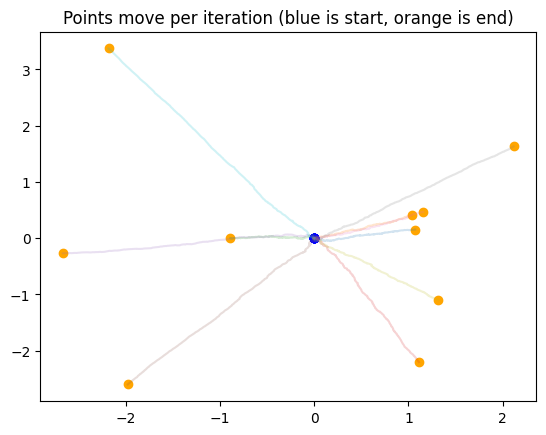

In [135]:


dis = np.array(dis)
for p in range(d0.shape[0]):
    plt.scatter(dis[0, p, 0], dis[0, p, 1], c="blue") # start
    plt.scatter(dis[-1, p, 0], dis[-1, p, 1], c="orange") # end
    plt.plot(dis[:, p, 0], dis[:, p, 1], alpha=0.2)
plt.title("Points move per iteration (blue is start, orange is end)")



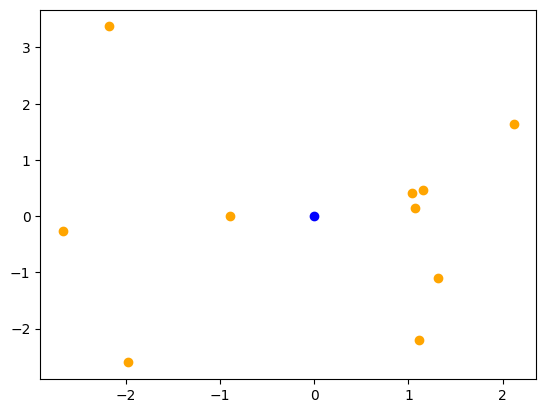

In [136]:
i = -1
plt.scatter(dis[0, p, 0], dis[0, p, 1], c="blue") # start
plt.scatter(dis[i, :, 0], dis[i, :, 1], c="orange")

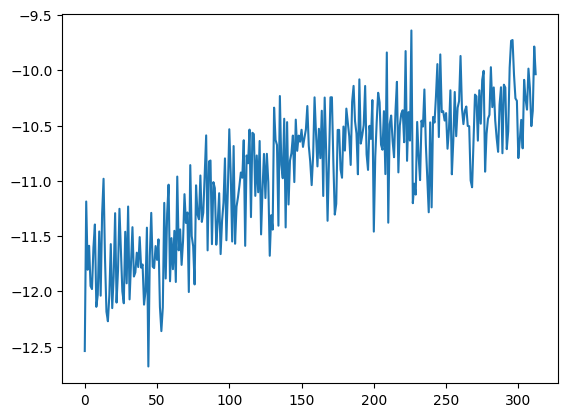

In [127]:
plt.plot(list(range(len(mis))), mis)

# Tests

In [ ]:
# Problem: The chain rule application into jacobian + lambda-grad does not work
theta_j = mean_prior
d = d0
y_ij = augment_d(d0) @ mean_prior + np.random.randn(10)
q_params = get_posterior(d, y)

In [ ]:

def q(d):
    d = decode_d(d)
    q_params = get_posterior(d, y_ij)
    return stable_multivariate_gaussian_logpdf(theta_j, q_params[0], q_params[1] @ q_params[1].T)
def g(d):
    return encode_q_params(get_posterior(d, y_ij))
def q_(theta, lam):
    mean, A = decode_q_params(lam)
    return np.exp(stable_multivariate_gaussian_logpdf(theta, mean, A @ A.T))
expected = grad(lambda d: np.exp(q(d)))(encode_d(d))
#g1 = grad(lambda d: q_(theta_j, g(d)))(d)
g1 = grad(lambda lam: q_(theta, lam))(encode_q_params(get_posterior(d, y_ij)))
print(g1)


#g2 = reshape_jacobian(jacobian(lambda d: encode_q_params(get_posterior(d, y_ij)))(d))
g2 = reshape_jacobian(jacobian(g)(d))
actual = g1 @ g2

In [ ]:
expected

In [ ]:
actual

In [ ]:
 grad(lambda eq: np.exp(stable_multivariate_gaussian_logpdf(theta_j, decode_q_params(eq)[0], decode_q_params(eq)[1])))(encode_q_params((np.ones(3)*2, np.eye(3))))

In [ ]:
decode_q_params(jacobian(lambda ed: encode_q_params(get_posterior(decode_d(ed), y_ij[0:2])))(encode_d(d[0:2]))[:,0])

In [ ]:
def test_f(ed):
    print(ed)
    return encode_q_params(get_posterior(decode_d(ed), y_ij))
jacobian(test_f)(encode_d(d))

In [ ]:
get_posterior(d, y_ij)

# Autograd IFT test

In [ ]:
def q(theta,lam):
    mean, A = decode_q_params(lam)
    return np.exp(stable_multivariate_gaussian_logpdf(theta, mean, A @ A.T))
def g(d):
    return encode_q_params(get_posterior(d, y_ij))
def reshape_jacobian(jac):
    return np.array([encode_d(jac[i]) for i in range(jac.shape[0]) ])

In [ ]:
q(theta, g(d))
grad(lambda d: q(theta, g(d)))(d)

In [ ]:
g1

In [ ]:
grad(lambda lam: q(theta, lam))(encode_q_params(get_posterior(d, y_ij)))

In [ ]:
(grad(lambda lam: q(theta, lam))(encode_q_params(get_posterior(d, y_ij))) @ encode_jacobian(jacobian(g)(d))).reshape(d.shape[0], d.shape[1])

In [ ]:
reshape_jacobian(jacobian(g)(d))

In [ ]:
d.shape

# Other Tests

In [ ]:
grad(MI)(d0)

In [ ]:
MI_grad_1(d0)

In [ ]:
grad(lambda d: MI(d, N= 100))(d0) - MI_grad_2(d0)

In [ ]:
zs = np.random.randn(10, 3)
mean_prior + A_prior @ zs[0]